In [1]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from hdbscan import HDBSCAN
from scipy.cluster import hierarchy
from sklearn.metrics import silhouette_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

In [2]:
# load dataset
df = pd.read_csv('../files/bank.csv')
print(df.shape)
df.columns

(11162, 17)


Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')

In [3]:
# checking na
print(df.isna().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64


## preprocessing

In [4]:
# checking dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


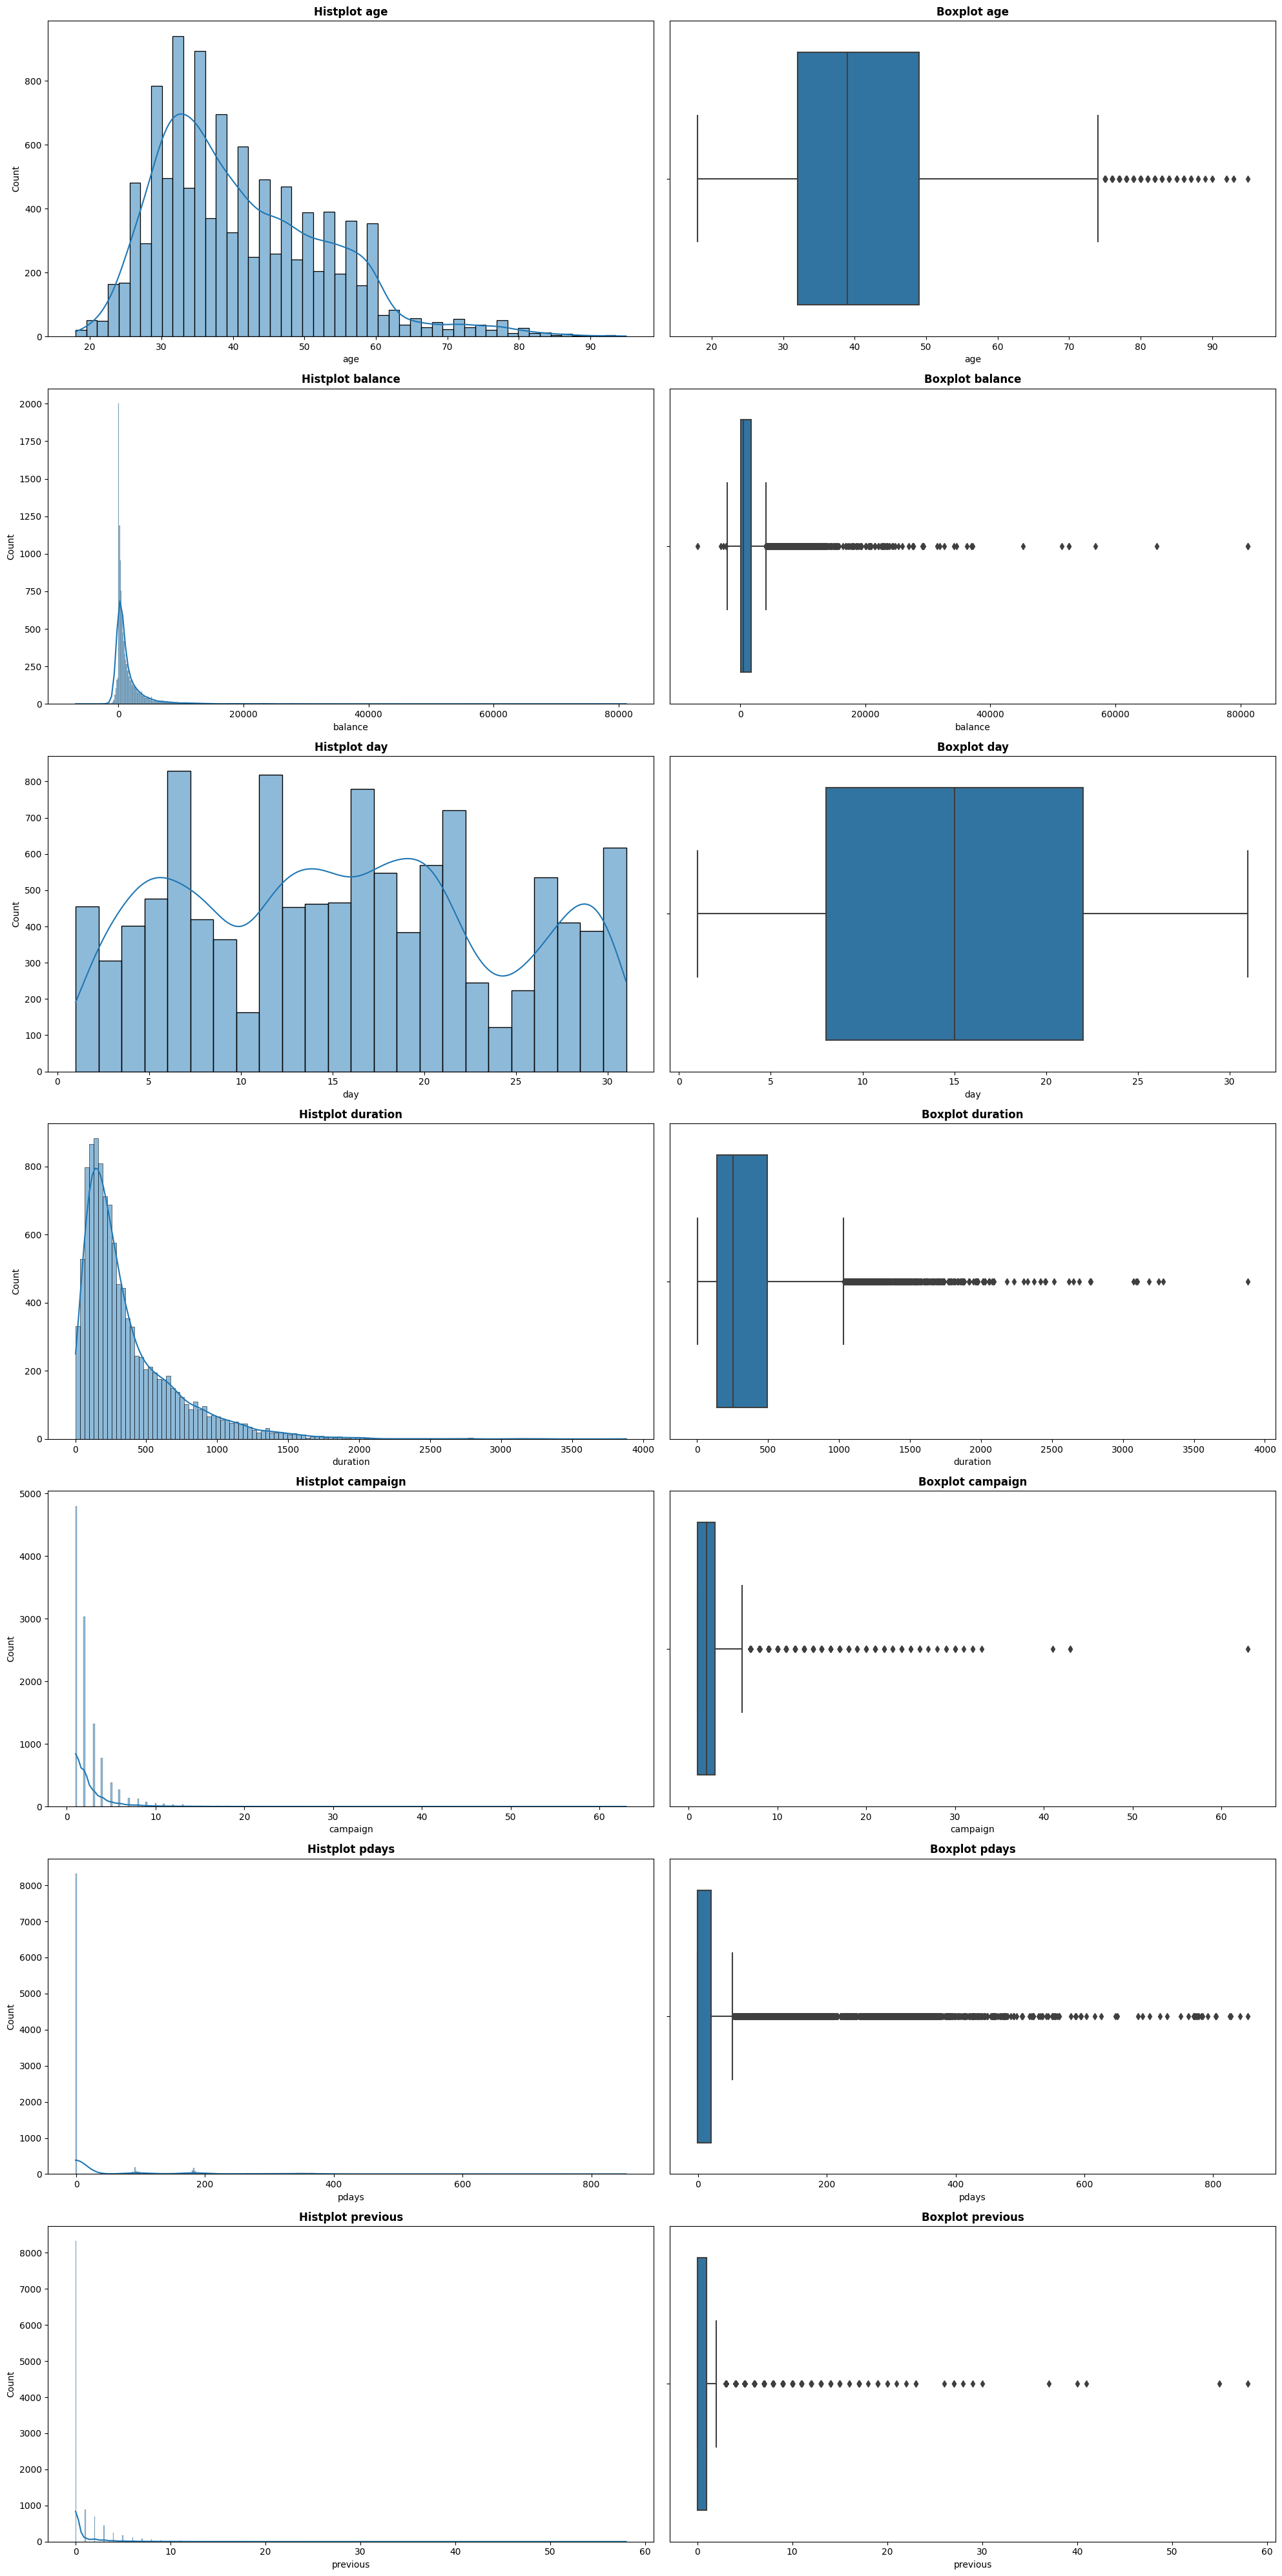

In [5]:
# checking numerical features
numerical_features = df.select_dtypes(include=['int', 'float']).columns
fig, ax = plt.subplots(nrows=len(numerical_features), ncols=2, figsize=(20,40))

for i, feature in enumerate(numerical_features):
    ax[i][0] = sns.histplot(x=df[feature], ax=ax[i][0], kde=True)
    ax[i][0].set_title(f'Histplot {feature}',fontdict={'fontsize': 12,'fontweight':'bold'})
    ax[i][1] = sns.boxplot(x=df[feature], ax=ax[i][1])
    ax[i][1].set_title(f'Boxplot {feature}',fontdict={'fontsize': 12,'fontweight':'bold'})

plt.tight_layout()
plt.show()

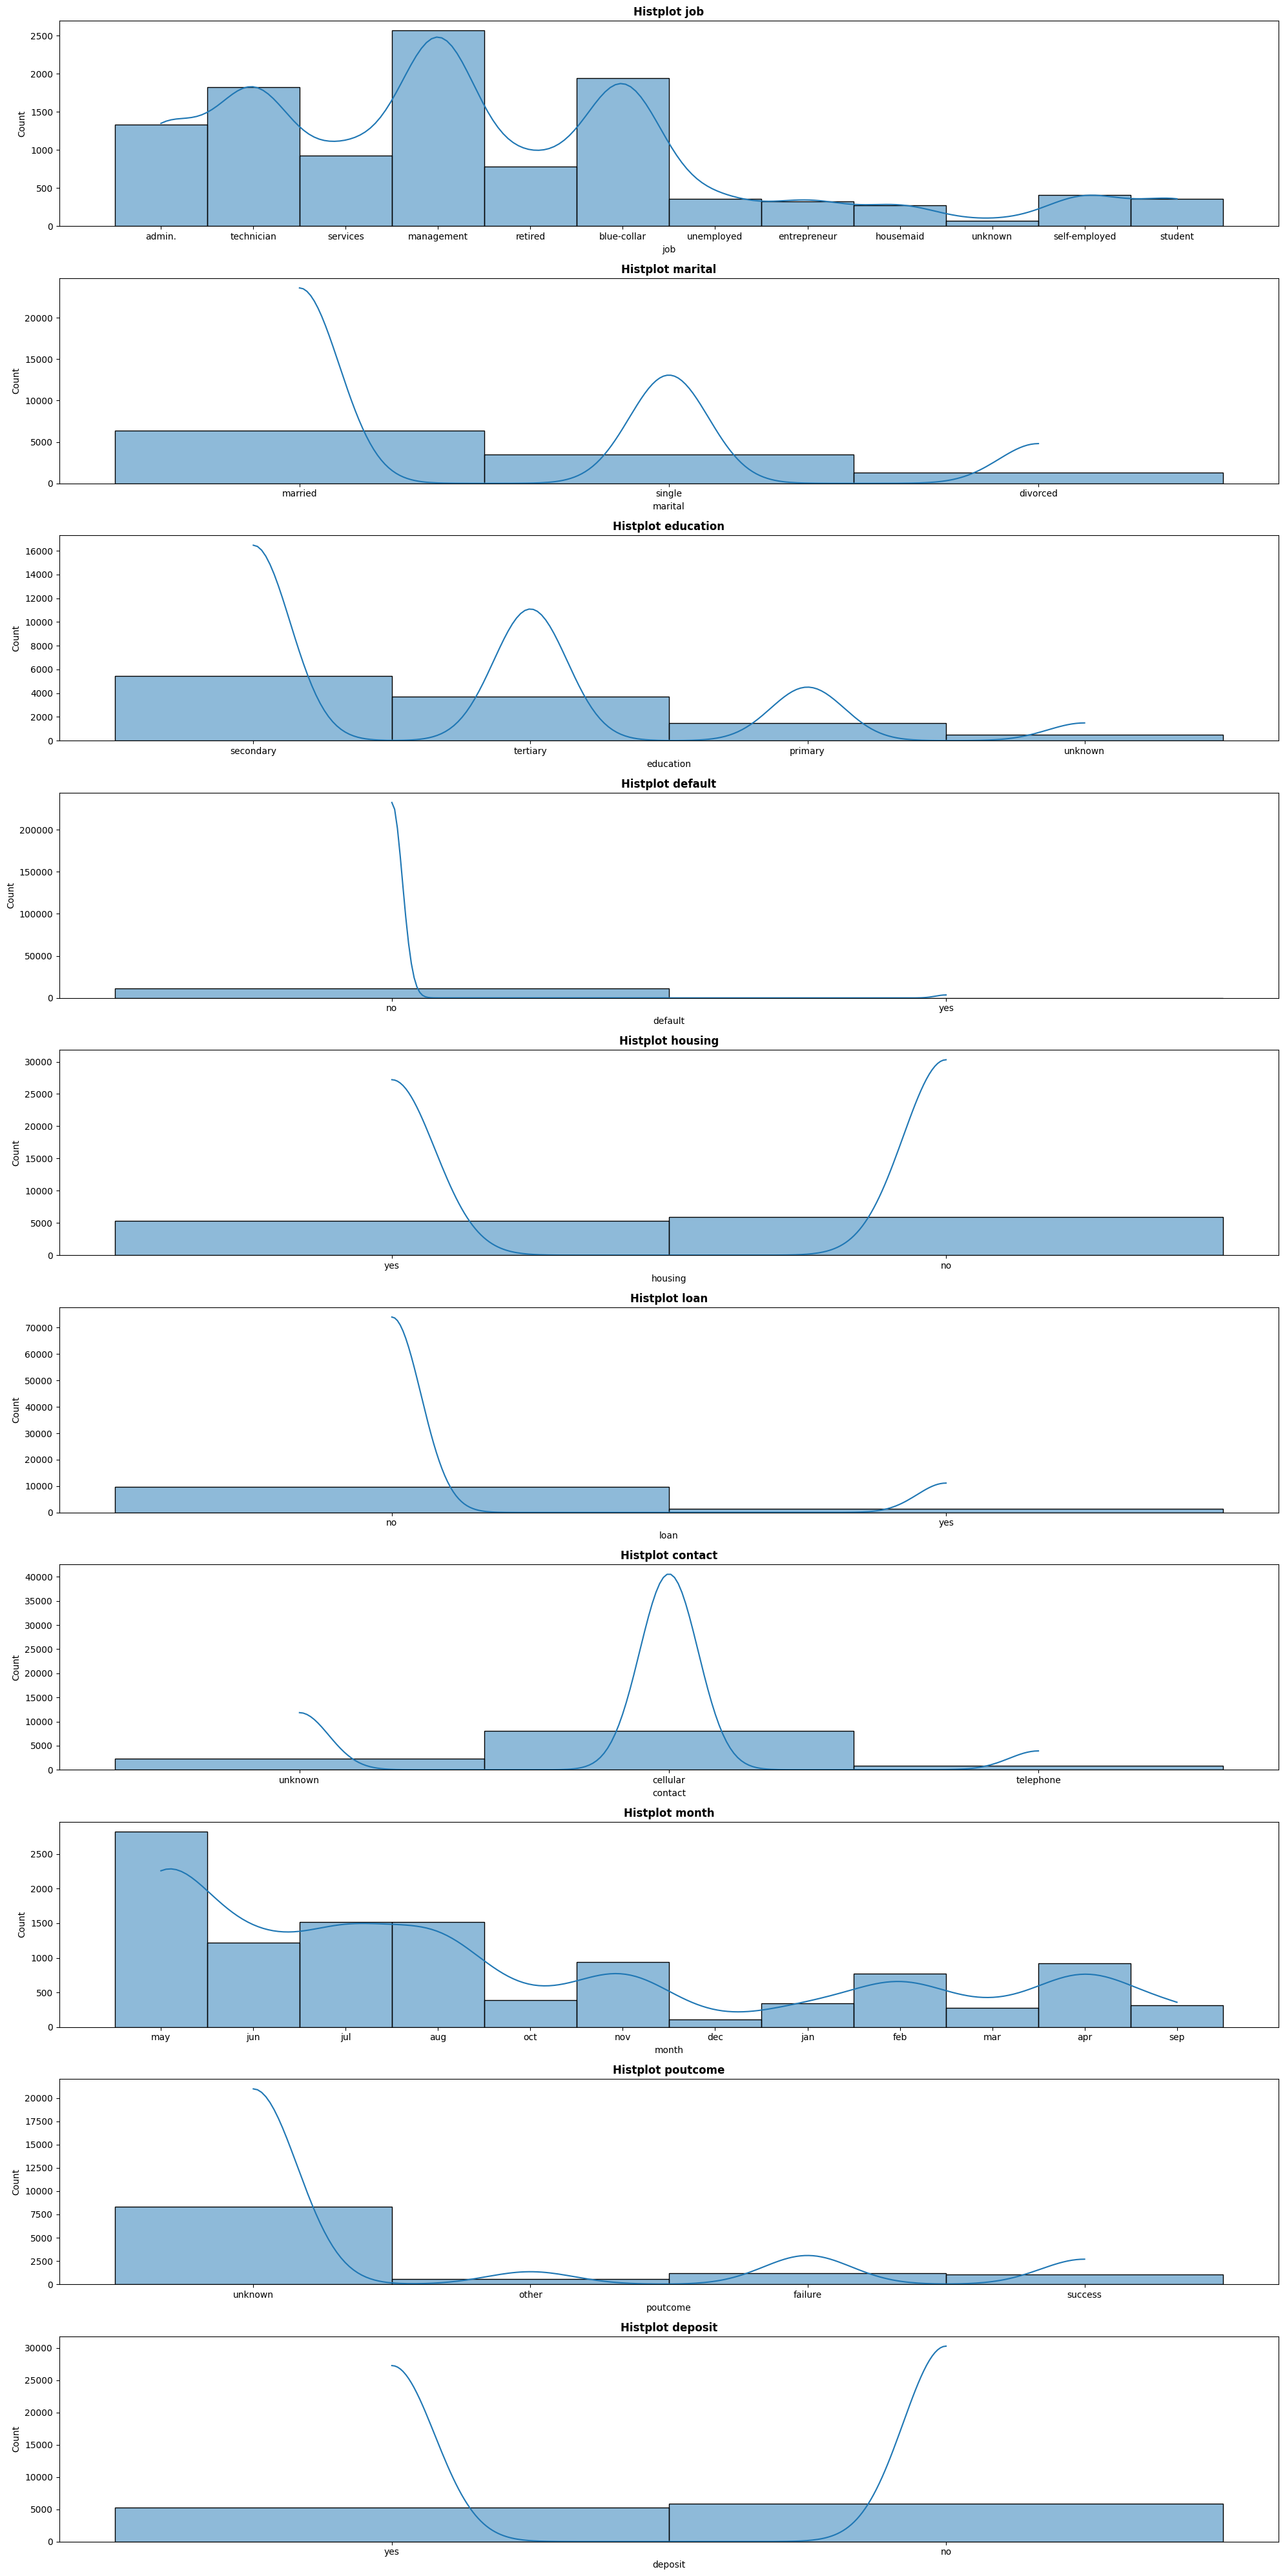

In [6]:
# checking object features
numerical_features = df.select_dtypes(include=['object']).columns
fig, ax = plt.subplots(nrows=len(numerical_features), ncols=1, figsize=(20,40))

for i, feature in enumerate(numerical_features):
    ax[i] = sns.histplot(data=df, x=feature, ax=ax[i], kde=True)
    ax[i].set_title(f'Histplot {feature}',fontdict={'fontsize': 12,'fontweight':'bold'})

plt.tight_layout()
plt.show()

In [7]:
# removing 'unknown' and droping features
# removing data
print(f'Shape df before droping numerical data: {df.shape}')
df = df.drop(['contact', 'poutcome'], axis=1)
df = df.replace({'unknown': np.nan})
df = df.dropna()
print(f'Shape df after droping numerical data: {df.shape}')

Shape df before droping numerical data: (11162, 17)
Shape df after droping numerical data: (10634, 15)


In [8]:
X = df.drop('deposit', axis=1).copy()
y = df['deposit'].copy()
# encoding target y
le = LabelEncoder()
y = le.fit_transform(y)

# tts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# KFolds definition
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# transformations
to_scalar = X.select_dtypes(include=['int', 'float']).columns
to_onehot = ['job', 'marital', 'default', 'housing', 'loan', 'month']
to_ordinal = ['education']

categories_education = [['primary', 'secondary', 'tertiary']]

# preprocessor
preprocessor = ColumnTransformer(transformers=[('scalar',
                                                Pipeline(steps=[('scalar', StandardScaler())]),
                                                to_scalar),
                                               ('onehot',
                                                Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))]),
                                                to_onehot),
                                               ('ordinal',
                                                Pipeline(steps=[('ordinal', OrdinalEncoder(categories=categories_education,
                                                                                           handle_unknown='use_encoded_value', unknown_value=-1))]),
                                                to_ordinal)
                                               ],
                                 remainder='passthrough'
                                )

# report function
def report(X, y, model, df_model):
    """
        print best_params_, train_score, test_score, clasification_report and plot the confusion_matrix
    Args:
        X (pd DataFrame)
        y (series): target
        model (prediction model)
        df_model (pd DataFrame): created with cv.results_ attribute
    """
    print(f'best_params_: {model.best_params_}')
    train_score = (df_model.loc[df_model['rank_test_score'] == 1, 'mean_train_score']).values[0]
    print(f'Train_score: {train_score}')
    print(f'Test_score_: {model.best_score_}')

    y_test_hat = model.best_estimator_.predict(X)
    clasification_report = classification_report(y, y_test_hat)
    print(clasification_report)

    confusion = confusion_matrix(y, y_test_hat)
    disp = ConfusionMatrixDisplay(confusion)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

best_params_: {'rfc__n_estimators': 124, 'rfc__min_samples_split': 84, 'rfc__max_depth': 17, 'rfc__criterion': 'entropy', 'rfc__bootstrap': False}
Train_score: 0.9538570128495062
Test_score_: 0.909144776247732
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1123
           1       0.79      0.87      0.83      1004

    accuracy                           0.83      2127
   macro avg       0.83      0.83      0.83      2127
weighted avg       0.84      0.83      0.83      2127



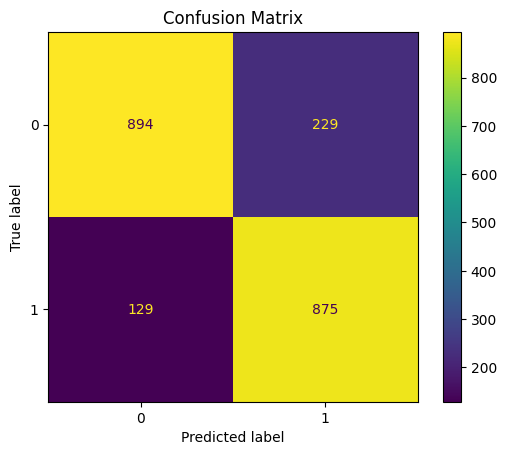

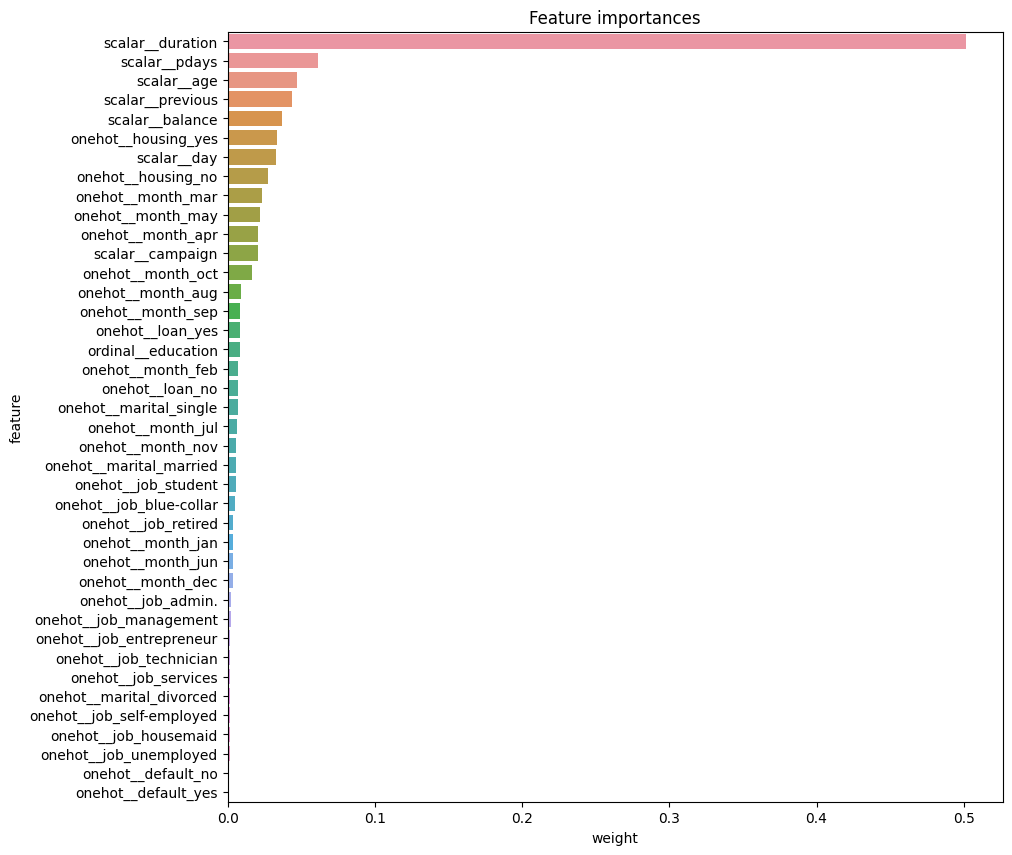

In [9]:
# GridSearchCV RFC
# pipe with preprocessor and model
pipe_rfc = Pipeline([('preprocessing', preprocessor),
                    ('rfc', RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42))
                    ])

# param_grid
param_grid = {
            'rfc__n_estimators': [x for x in range(90, 130, 1)],
            'rfc__criterion': ['gini', 'entropy'],
            'rfc__max_depth': [x for x in range(1, 30, 1)],
            'rfc__min_samples_split': [x for x in range(70, 90, 1)],
            'rfc__bootstrap': [True, False]
            }
RandomizedSearchCV
grid_rfc = RandomizedSearchCV(estimator=pipe_rfc,
                        param_distributions=param_grid,
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=skf,
                        return_train_score=True
                        )

grid_rfc.fit(X_train, y_train)

df_rfc = pd.DataFrame(grid_rfc.cv_results_)

# report
report(X_test, y_test, grid_rfc, df_rfc)

# plot feature importances
plt.figure(figsize=(10, 10))
rfc_feature_importante = pd.DataFrame({'feature': grid_rfc.best_estimator_[:-1].get_feature_names_out(),
                                       'weight': grid_rfc.best_estimator_.named_steps['rfc'].feature_importances_}).sort_values('weight',ascending=False).head(50)
sns.barplot(data=rfc_feature_importante, x='weight', y='feature')
plt.title('Feature importances')
plt.show()

In [10]:
# function to discretize features
def discretizer(df, feature, n_bins=5, encode='ordinal', strategy='quantile'):
    """
    returns a discretized feature
    Args:
        df (pd.DataFrame)
        feature (str): feature name
        n_bins (int, optional): Defaults to 5.
        encode (str, optional): Defaults to 'ordinal'.
        strategy (str, optional): Defaults to 'quantile'.
    """

    discretizer = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)
    discretizer.fit(df[[feature]])
    return (discretizer.transform(df[[feature]]), discretizer.bin_edges_)

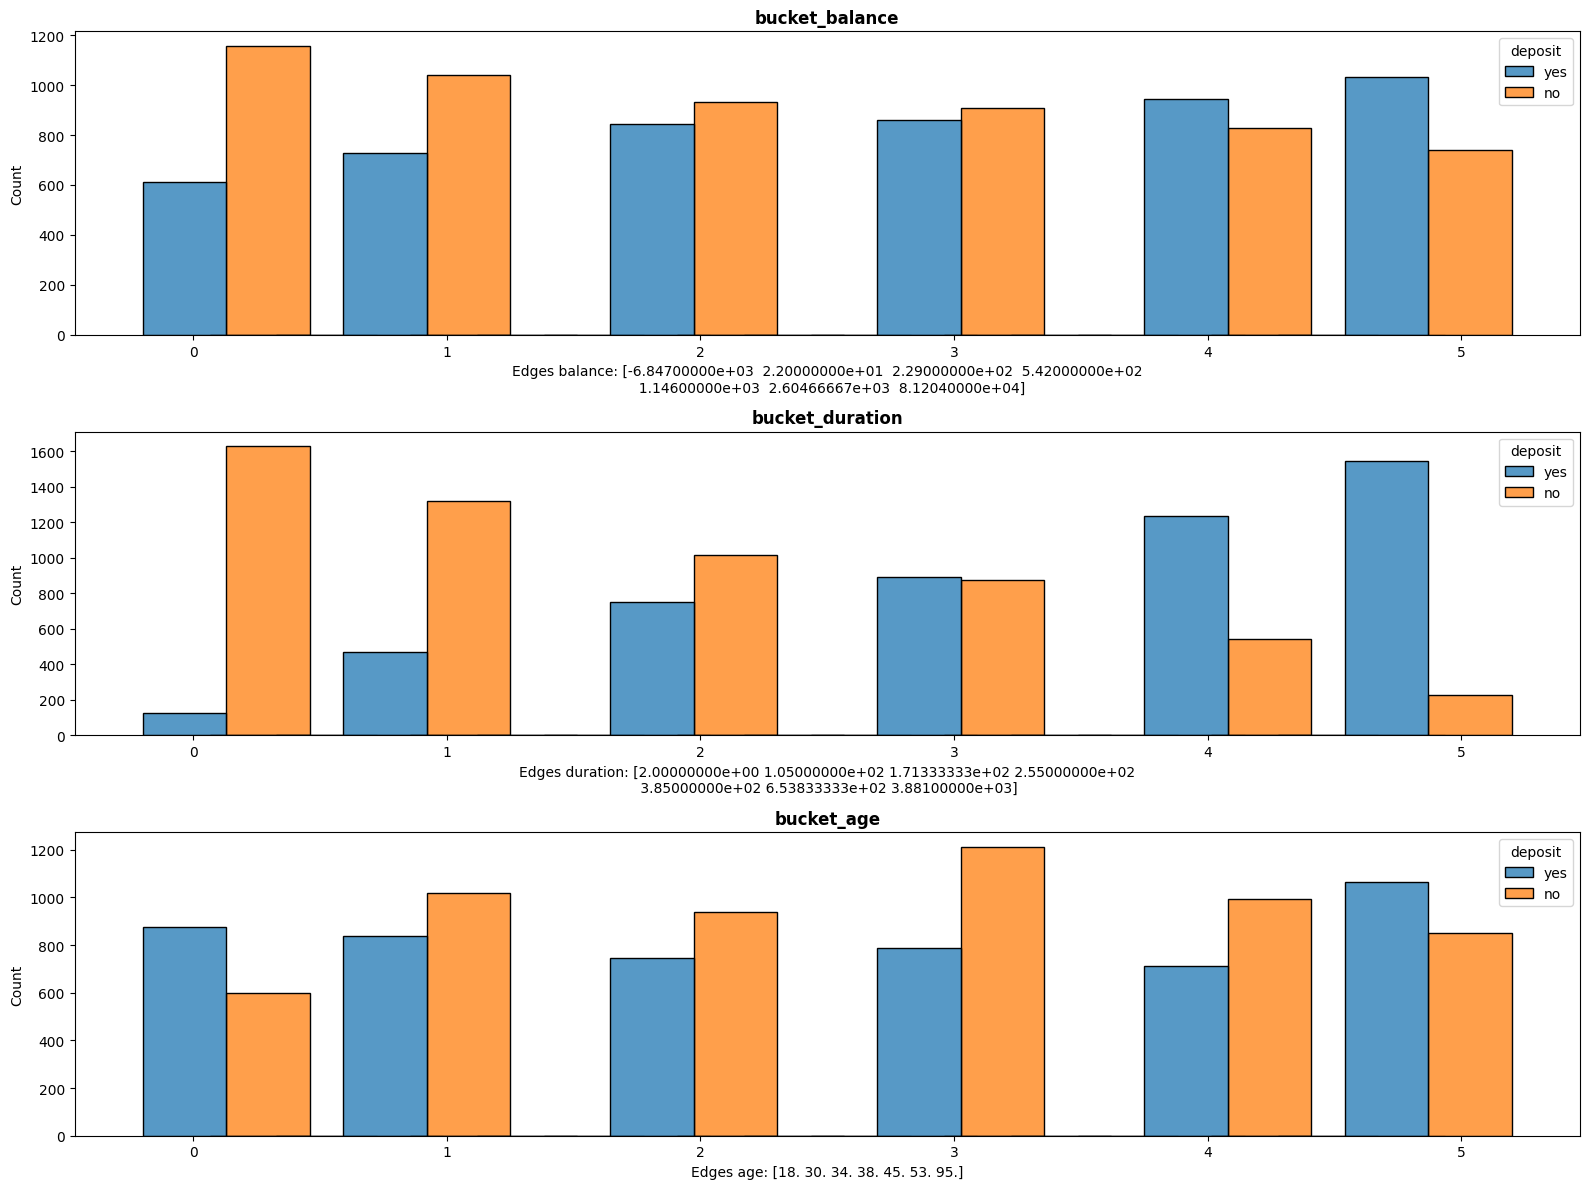

In [11]:
# buckets for 'balance', 'duration', 'age'
df['balance_buckets'], balance_edges = discretizer(df, 'balance', n_bins=5, encode='ordinal', strategy='quantile')
df['duration_buckets'], duration_edges = discretizer(df, 'duration', n_bins=5, encode='ordinal', strategy='quantile')
df['age_buckets'], age_edges = discretizer(df, 'age', n_bins=5, encode='ordinal', strategy='quantile')

# ploting buckets with hue 'deposit'
bucket_features = ['balance', 'duration', 'age']
fig, ax = plt.subplots(nrows=len(bucket_features), ncols=1, figsize=(16, 12))

for i, feature in enumerate(bucket_features):
    discretized_feature, edges = discretizer(df, feature, n_bins=6, encode='ordinal', strategy='quantile')
    df[f'bucket_{feature}'] = discretized_feature
    ax[i] = sns.histplot(data=df, x=f'bucket_{feature}', hue='deposit', multiple='dodge', shrink=2.5, ax=ax[i])
    ax[i].set_xlabel(f'Edges {feature}: {edges[0]}')
    ax[i].set_title(f'bucket_{feature}',fontdict={'fontsize': 12,'fontweight':'bold'})

plt.tight_layout()
plt.show()

## conclusions
1) People with account balance above $1146 are more likely to subscribe
2) People with duration above 255 are more likely to subscribe
3) People under 30 years old and above than 53 years old are more likely to subscribe

# unsupervised learning

In [12]:
# plot pca function
def plot_pca(X_pca, explained_variance):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 6))

    ax[0] = sns.lineplot(x=np.arange(0, len(explained_variance)), y=explained_variance, ax=ax[0])
    ax[0].set_xlabel('Number PC')
    ax[0].set_ylabel('% variance')
    ax[0].set_title('Explained variance PCA')
    ax[0].grid(0.3)

    cumulative = np.cumsum(explained_variance)
    ax[1] = sns.lineplot(x=np.arange(0, len(explained_variance)), y=cumulative, ax=ax[1])
    ax[1].set_yticks(np.arange(0, 1, 0.05))
    ax[1].set_xticks(range(0, X_pca.shape[1]))
    ax[1].set_xlabel('Number PC')
    ax[1].set_ylabel('% variance')
    ax[1].set_title('Explained variance PCA')
    ax[1].grid(0.3)

    plt.tight_layout()
    plt.show()


# plot kmeans function
def plot_kmeans(n_clusters, metric_list, method):

    plt.figure(figsize = (10, 5))
    plt.plot(n_clusters, metric_list)
    plt.scatter(n_clusters, metric_list, c='r')
    plt.xlabel('Number of clusters')
    plt.grid(0.3)
    if method == 'i':
        plt.ylabel('Average inertia')
        plt.title('Elbow method')
    if method == 's':
        plt.ylabel('Average silhouette')
        plt.title('Silhouette method')
    plt.show()


# function to plot clusters
def cluster_plot(dict, str_parameters):

    fig, ax = plt.subplots(nrows=len(dict), ncols=1, figsize=(10, 30))
    for i, (key, value) in enumerate(dict.items()):
        ax[i] = sns.barplot(x=value[0], y=value[1], ax=ax[i])
        ax[i].set_title(f'{str_parameters}: [{key}]', fontdict={'fontsize': 12,'fontweight':'bold'})
        ax[i].set_ylabel('Count')
        ax[i].set_xlabel(f'Clusters')
        ax[i].grid(linewidth=0.3)
        for container in ax[i].containers:
            ax[i].bar_label(container)

    plt.tight_layout()
    plt.show()

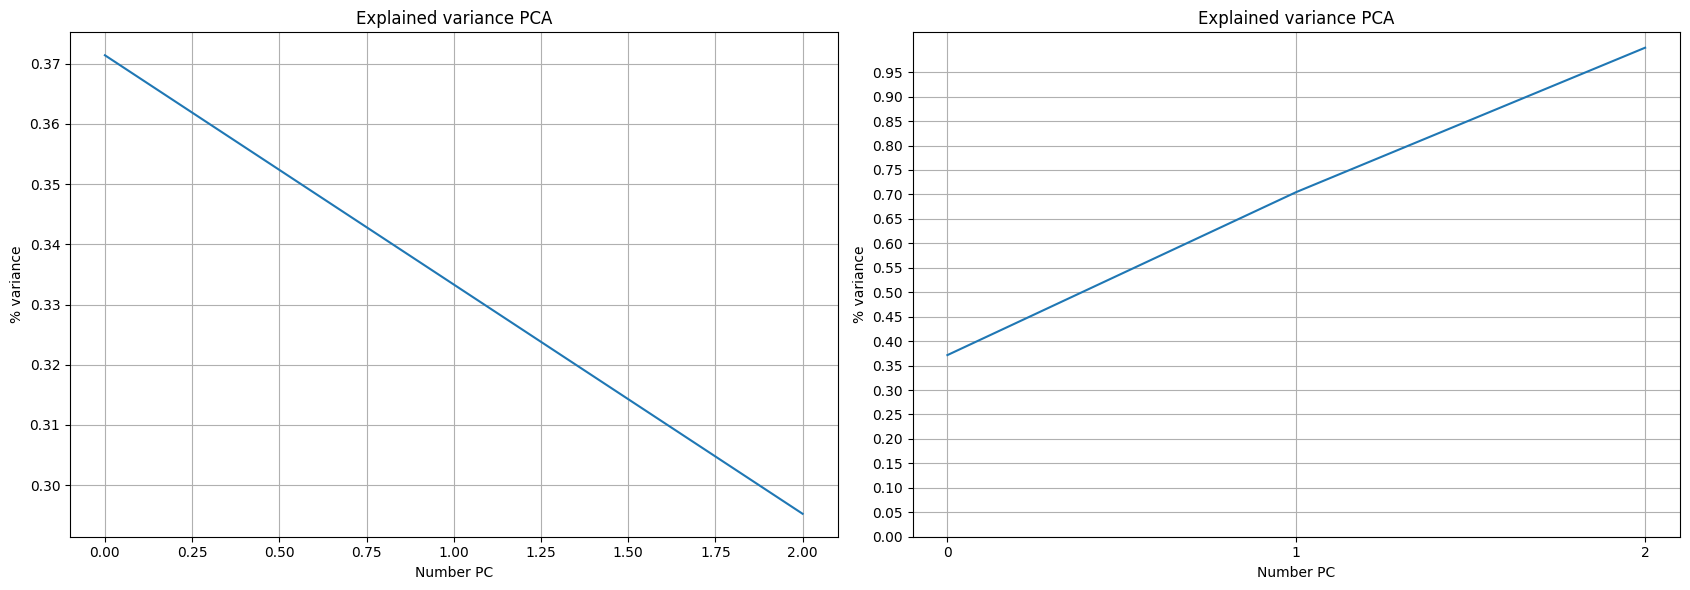

In [45]:
# PCA should be used only with non-categorical features

quantitative_features = ['balance', 'duration', 'age']
X = X[quantitative_features].copy()

preprocessor = ColumnTransformer(transformers=[('scalar',
                                                Pipeline(steps=[('scalar', StandardScaler())]),
                                                quantitative_features)
                                               ],
                                 remainder='passthrough'
                                )

# preprocess without PCA
pipe_pre = Pipeline([('preprocessing', preprocessor)
                    ])
X_pre = pipe_pre.fit_transform(X)

# preprocess with PCA
pipe_pca = Pipeline([('preprocessing', preprocessor),
                    ('pca', PCA(random_state=42))
                    ])
pipe_pca.fit(X)

X_pca = pipe_pca.transform(X)
explained_variance = pipe_pca['pca'].explained_variance_ratio_

plot_pca(X_pca, explained_variance)

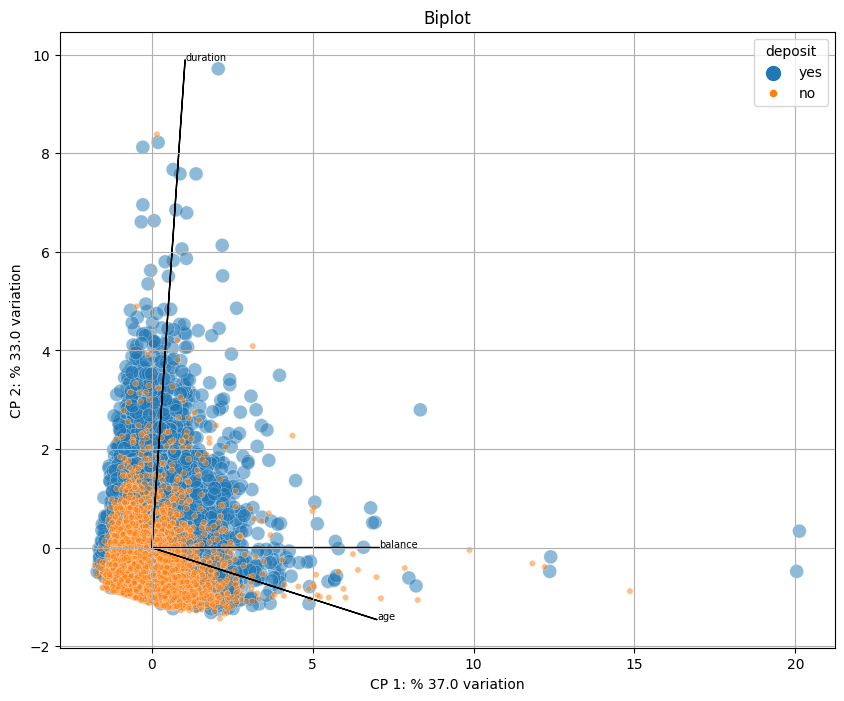

In [14]:
# biplot
def biplot_pca(X_pca, model, components=(0, 1), arrows=True, hue=None):
    """
    make a PCA biplot
    Args:
        X_pca (X matrix)
        model (pca model)
        components (tuple): components to plot, default PC0 and PC1
        arrows (bool, optional): if True: plot arrows
        hue (1d array)
    """
    features_pc = model.components_.T
    explained_variance = model.explained_variance_ratio_
    fig, ax = plt.subplots(figsize=(10, 8))
    if hue is not None:
        ax = sns.scatterplot(x=X_pca[:, components[0]], y=X_pca[:, components[1]], alpha=0.5, ax=ax,
                             hue=hue, size=hue, sizes=(20, 100))
    else:
        ax = sns.scatterplot(x=X_pca[:, components[0]], y=X_pca[:, components[1]], alpha=0.5, ax=ax)
    ax.set_xlabel(f'CP 1: % {round(explained_variance[0], 2)*100} variation')
    ax.set_ylabel(f'CP 2: % {round(explained_variance[1], 2)*100} variation')
    ax.set_title('Biplot')
    ax.grid(0.3)
    if arrows:
        stretching = 10
        for x in range(len(X.columns)):
                ax.arrow(x=0,
                        y=0,
                        dx=stretching*features_pc[x][0],
                        dy=stretching*features_pc[x][1]
                        )
                ax.text(stretching*features_pc[x][0],
                        stretching*features_pc[x][1],
                        s=X.columns[x],
                        size=7
                        )
    plt.show()


biplot_pca(X_pca, pipe_pca['pca'], hue=df['deposit'])

# non-hierarchical clustering

## KMeans

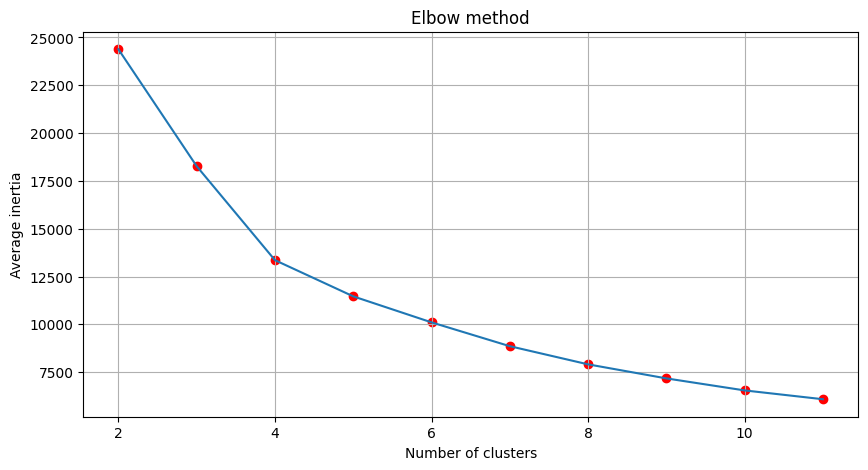

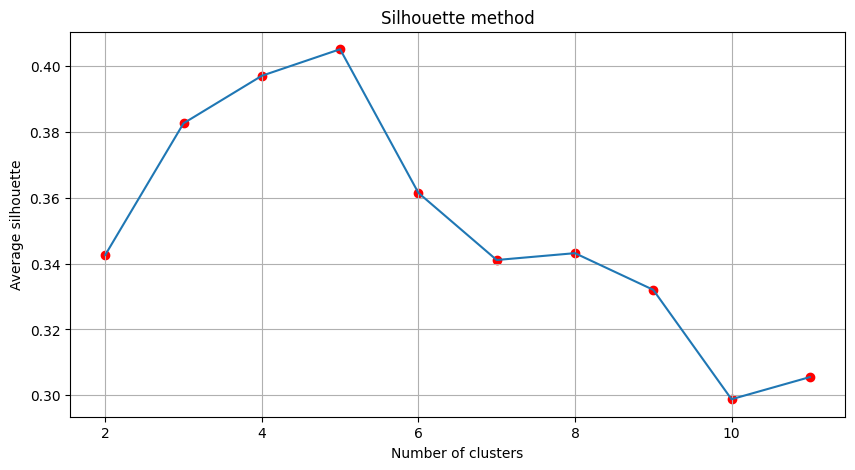

In [15]:
# elbow method
clusters = np.arange(2, 12)
inertia_list = []

for k in clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pre)
    inertia_list.append(kmeans.inertia_)

plot_kmeans(clusters, inertia_list, method='i')


# silhouette method
clusters = np.arange(2, 12)
silhouette_list = []

for k in clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pre)
    silhouette_list.append(silhouette_score(X_pre, kmeans.labels_))

plot_kmeans(clusters, silhouette_list, method='s')

In [46]:
# KMeans with 4 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_pre)
df['clusters_kmeans'] = kmeans.labels_

## DBSCAN

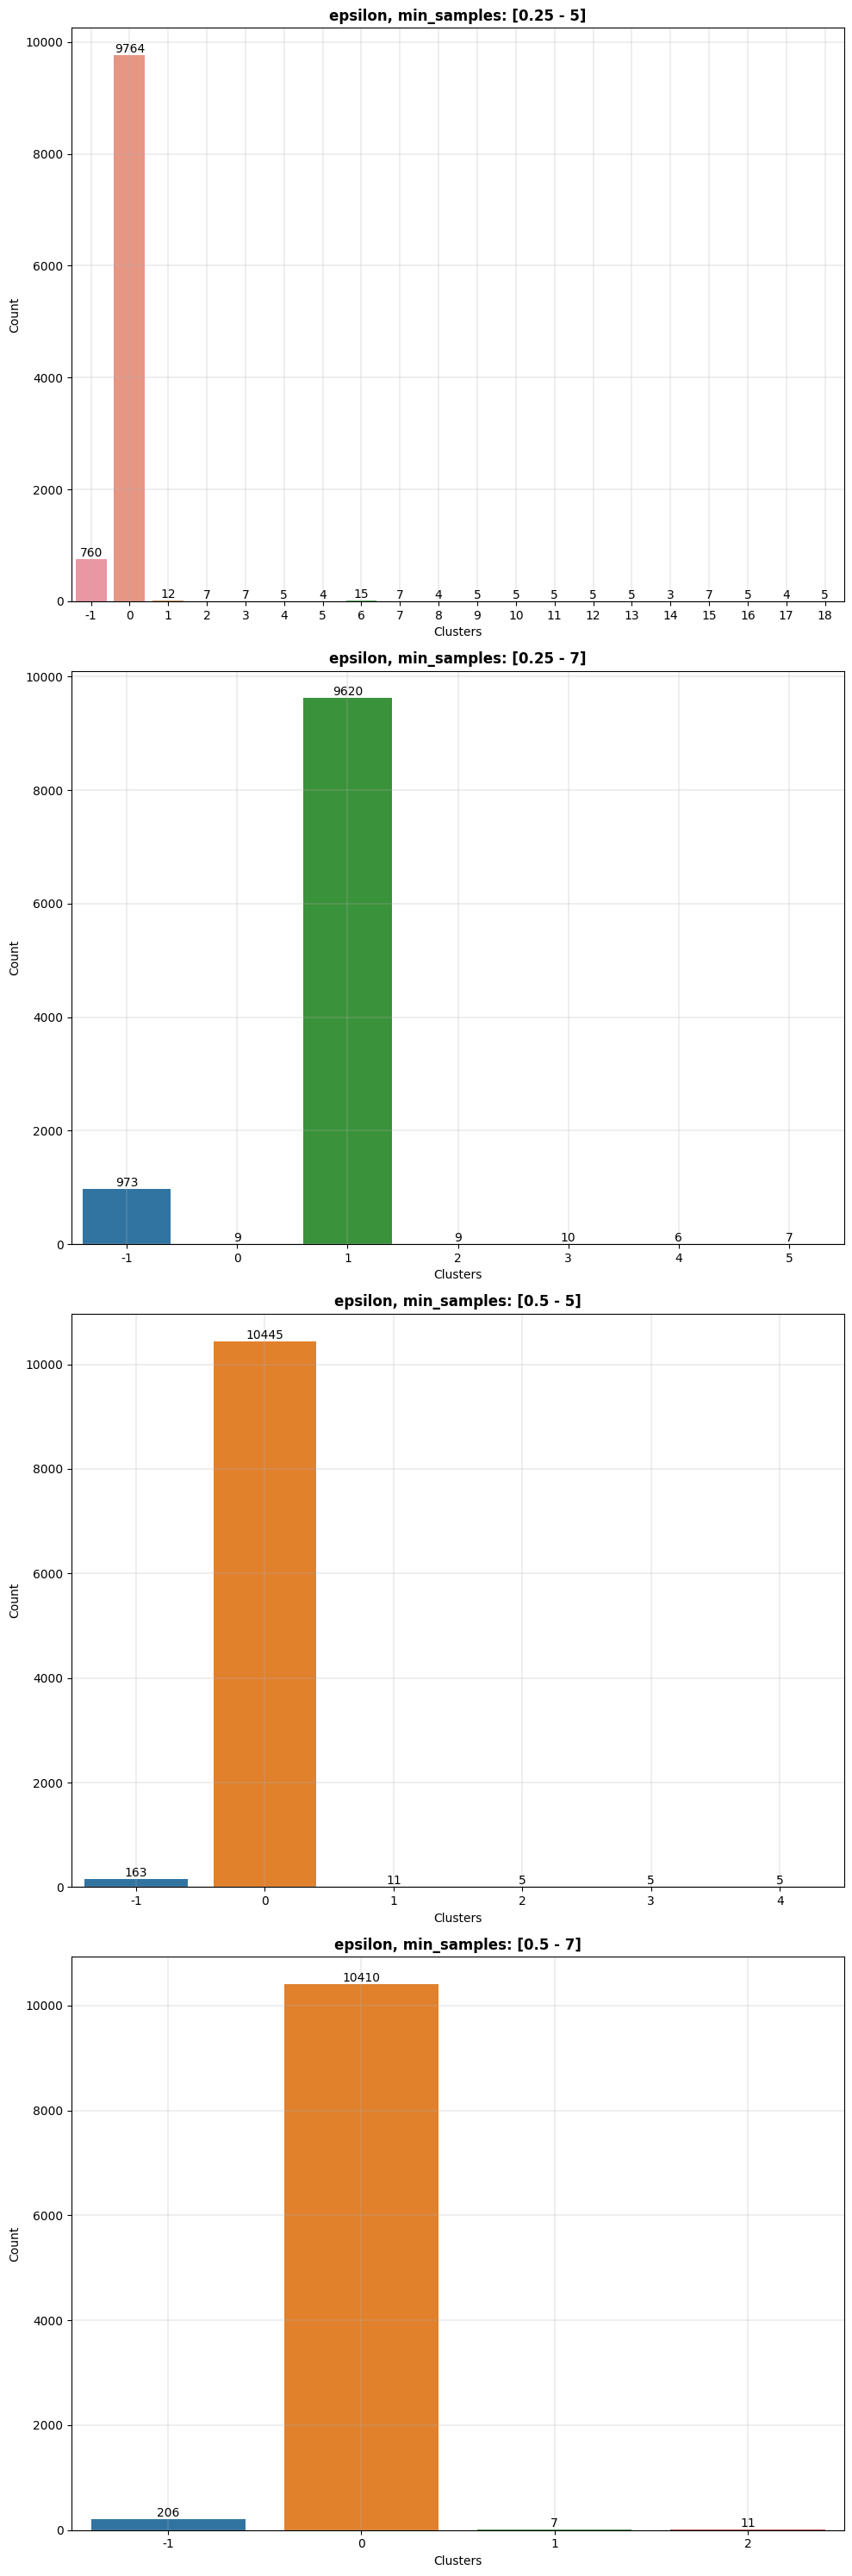

In [26]:
epsilon = [0.25, 0.5]
min_samples = [5, 7]
dict = {} # to store models information

for eps in epsilon:
    for ms in min_samples:
        dbscan = DBSCAN(eps=eps, min_samples=ms)
        dbscan.fit(X_pre)
        labels = dbscan.labels_
        dict[str(eps) + ' - ' + str(ms)] = np.unique(labels, return_counts=True) # storing information about the model in a dictionary

cluster_plot(dict, 'epsilon, min_samples')

## HDBSCAN

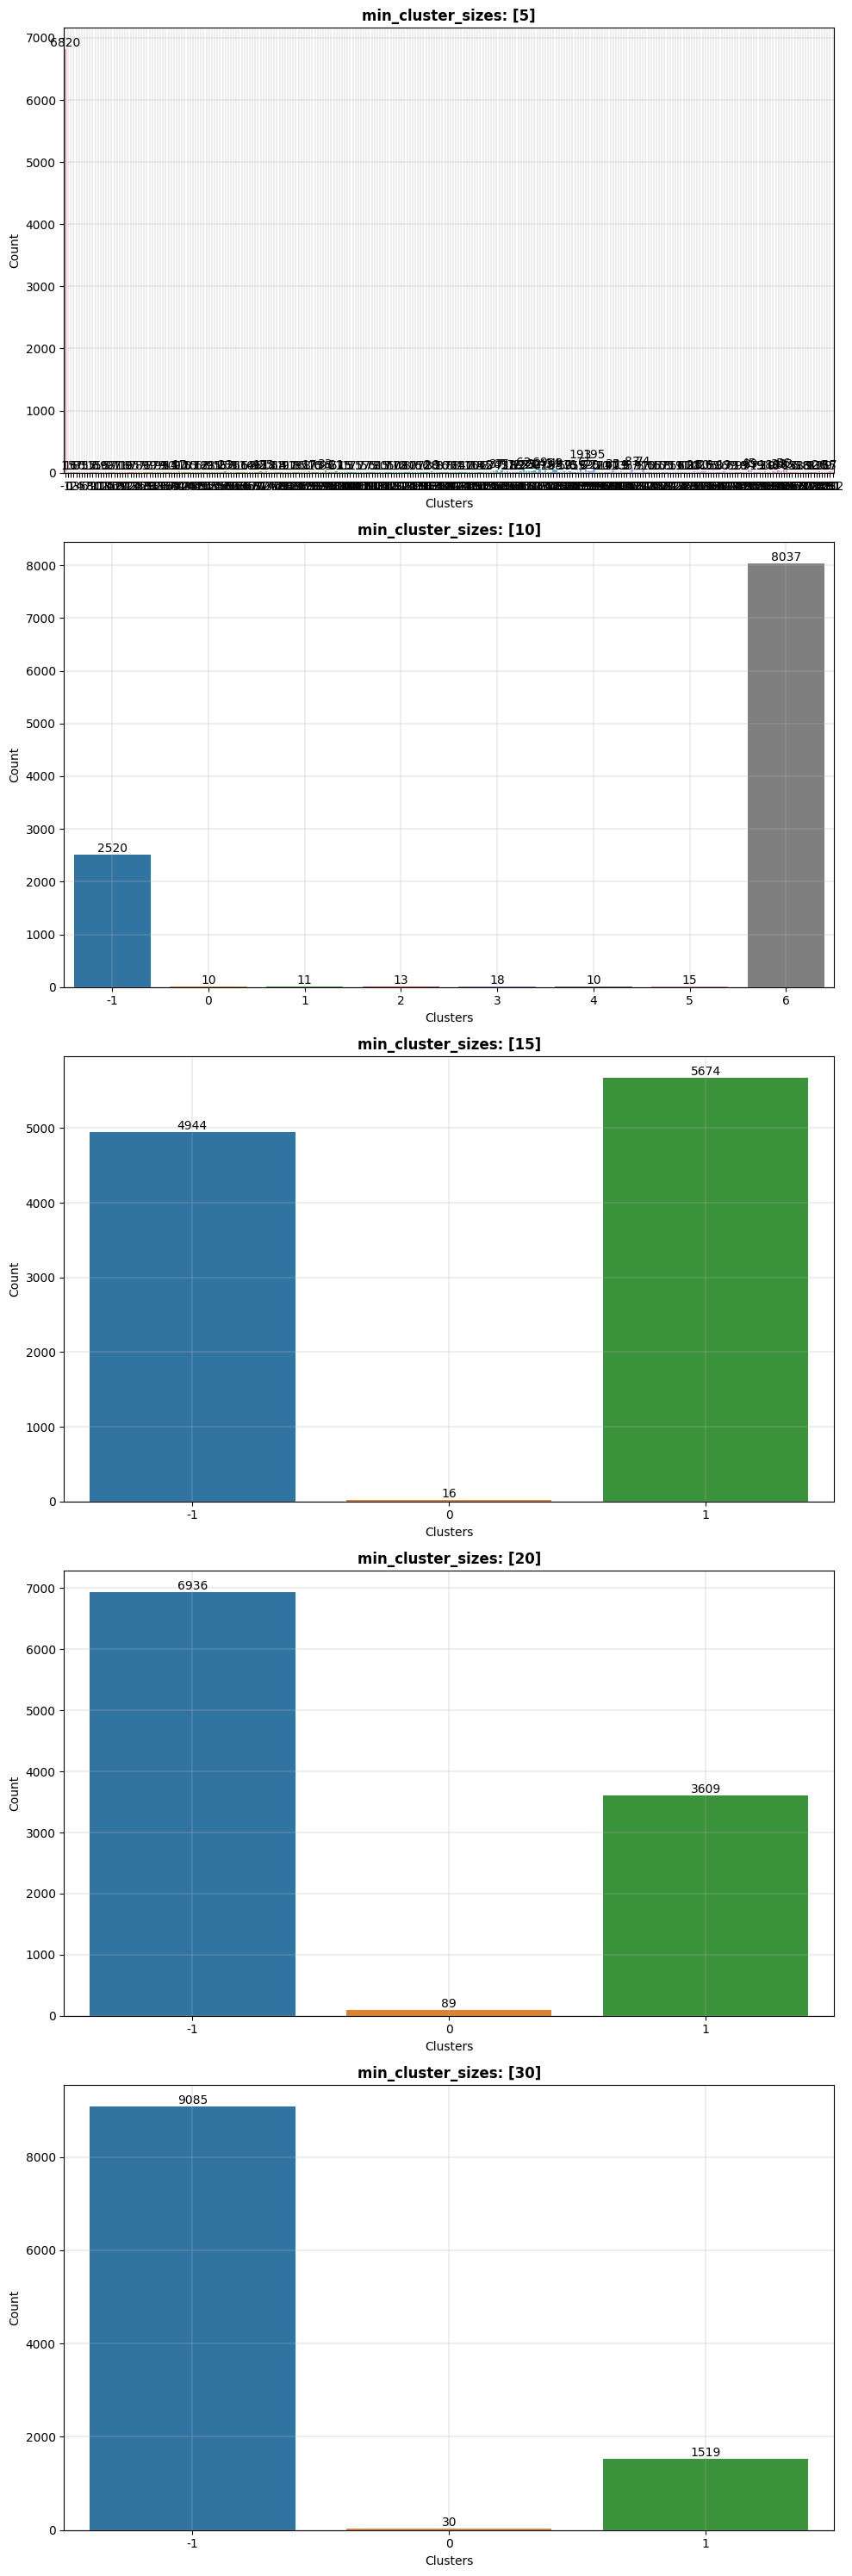

In [25]:
min_cluster_sizes = [5, 10, 15, 20, 30]
dict = {} # to store models information

for mcs in min_cluster_sizes:
    hdbscan = HDBSCAN(min_cluster_size=mcs, gen_min_span_tree=True, algorithm='best')
    hdbscan.fit(X_pre)
    hdbscan_labels = hdbscan.labels_
    dict[str(mcs)] = np.unique(hdbscan_labels, return_counts=True) # storing information about the model in a dictionary

cluster_plot(dict, 'min_cluster_sizes')

## non-hierarchical cluster analysis is inconclusive

## hierarchical clustering

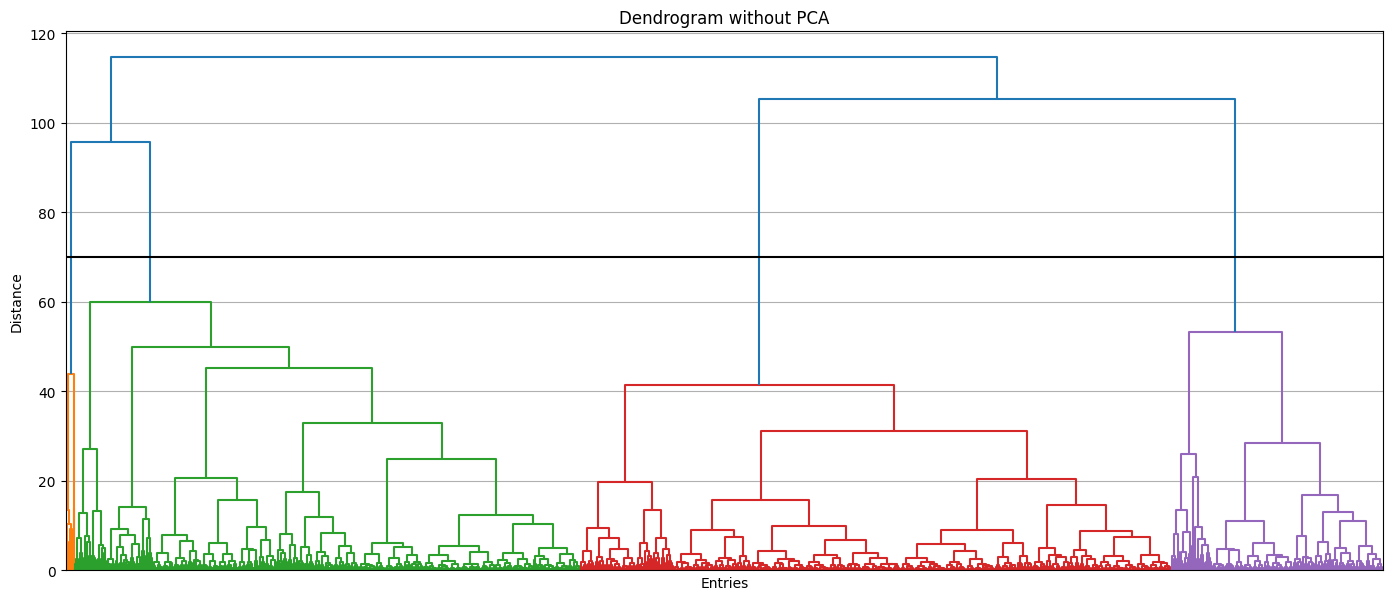

In [50]:
# dendrogram without pca
plt.figure(figsize=(17, 7))
dendro = hierarchy.dendrogram(hierarchy.linkage(X_pre, method='ward')) # ward's criterion minimizes the total variance within clusters
plt.title('Dendrogram without PCA')
plt.xticks([])
plt.xlabel('Entries')
plt.ylabel('Distance')
plt.grid(0.3)
plt.axhline(y=70, color='black')
plt.show()

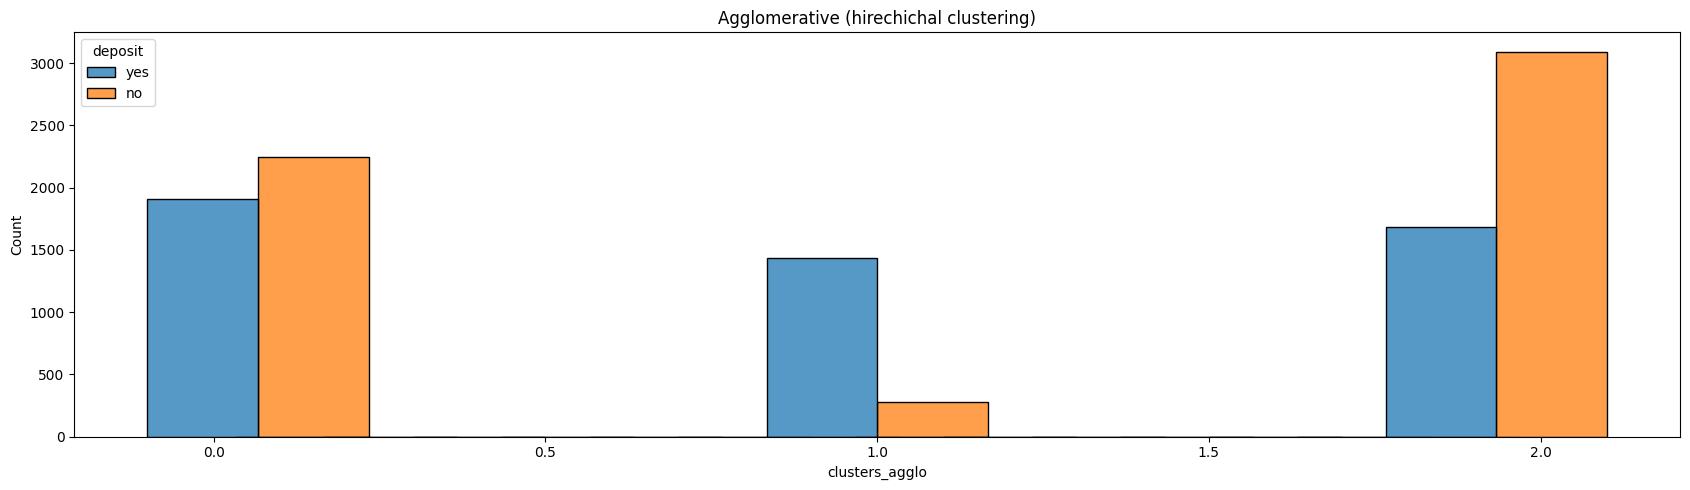

In [35]:
# agglomerative clustering with pca and 3 clusters
agglo_clustering = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
agglo_clustering.fit(X_pre)
df['clusters_agglo'] = agglo_clustering.labels_

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(17, 5))
ax = sns.histplot(data=df, x='clusters_agglo', hue='deposit', multiple='dodge', shrink=2.5, ax=ax)
ax.set_title('Agglomerative (hirechichal clustering)')
plt.tight_layout()
plt.show()

In [36]:
df.head()

,age,job,marital,education,default,balance,housing,loan,day,month,...,previous,deposit,balance_buckets,duration_buckets,age_buckets,bucket_balance,bucket_duration,bucket_age,clusters_agglo,clusters_kmeans
0,59,admin.,married,secondary,no,2343,yes,no,5,may,...,0,yes,4.0,4.0,4.0,4.0,5.0,5.0,1,2
1,56,admin.,married,secondary,no,45,no,no,5,may,...,0,yes,0.0,4.0,4.0,1.0,5.0,5.0,1,2
2,41,technician,married,secondary,no,1270,yes,no,5,may,...,0,yes,3.0,4.0,2.0,4.0,5.0,3.0,1,2
3,55,services,married,secondary,no,2476,yes,no,5,may,...,0,yes,4.0,3.0,4.0,4.0,4.0,5.0,0,1
4,54,admin.,married,tertiary,no,184,no,no,5,may,...,0,yes,1.0,4.0,4.0,1.0,5.0,5.0,0,1


In [43]:
df.groupby('clusters_agglo').agg({'balance': ['mean', 'median', 'std'],
                                  'duration': ['mean', 'median', 'std'],
                                  'age': ['mean', 'median', 'std']})

balance                        duration         \
                       mean median          std        mean median   
clusters_agglo                                                       
0               2196.915001  692.0  4663.963099  321.972791  238.0   
1                825.858899  397.5  1216.457152  942.876464  860.0   
2               1174.837000  502.0  1737.928859  214.134716  196.0   

                                  age                   
                       std       mean median       std  
clusters_agglo                                          
0               248.417269  52.156754   51.0  9.380561  
1               404.511282  35.835480   34.0  8.466993  
2               125.435395  33.200922   33.0  5.114332